# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). If you use the Anaconda Python distribution, it is recommeded to install Tensorflow via the conda package manager: `conda install tensorflow-cpu`.

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

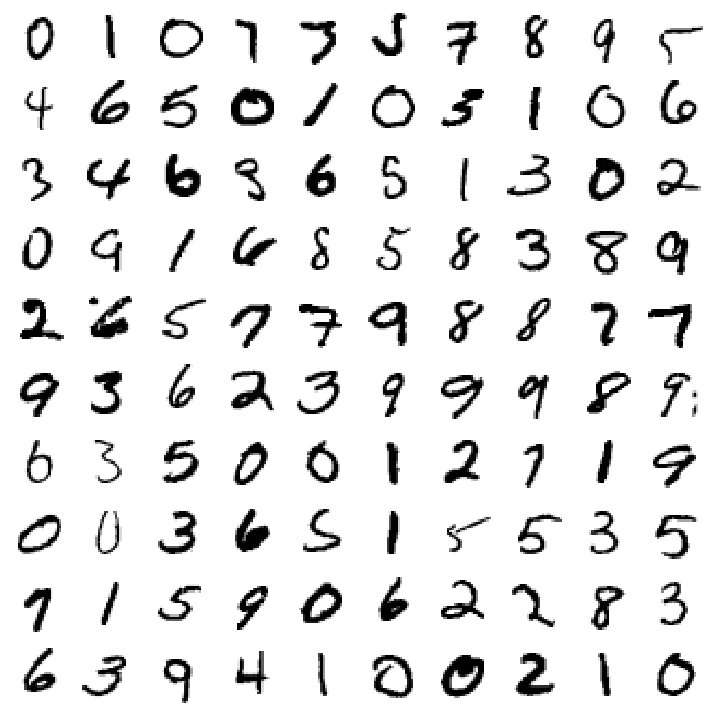

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

Compile and train the network (note that this could take a while).

In [22]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 118s 2ms/sample - loss: 0.2438 - accuracy: 0.9266 - val_loss: 0.0539 - val_accuracy: 0.9823
Epoch 2/12
60000/60000 [==============================] - 118s 2ms/sample - loss: 0.0860 - accuracy: 0.9739 - val_loss: 0.0405 - val_accuracy: 0.9861
Epoch 3/12
60000/60000 [==============================] - 124s 2ms/sample - loss: 0.0658 - accuracy: 0.9799 - val_loss: 0.0337 - val_accuracy: 0.9893
Epoch 4/12
60000/60000 [==============================] - 114s 2ms/sample - loss: 0.0518 - accuracy: 0.9846 - val_loss: 0.0305 - val_accuracy: 0.9897
Epoch 5/12
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0457 - accuracy: 0.9860 - val_loss: 0.0302 - val_accuracy: 0.9902
Epoch 6/12
60000/60000 [==============================] - 113s 2ms/sample - loss: 0.0388 - accuracy: 0.9878 - val_loss: 0.0343 - val_accuracy: 0.9895
Epoch 7/12
60000/60000 [==========================

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [23]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03122303096586777
Test accuracy: 0.9914


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. 

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

(20, 584, 565, 3)


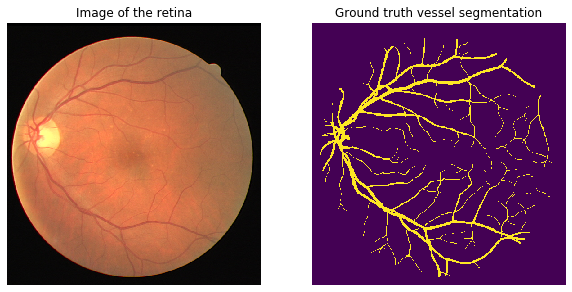

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
import sys
sys.path.append('code/')
from unet_utils import load_data

# location of the DRIVE dataset
data_folder = './data/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


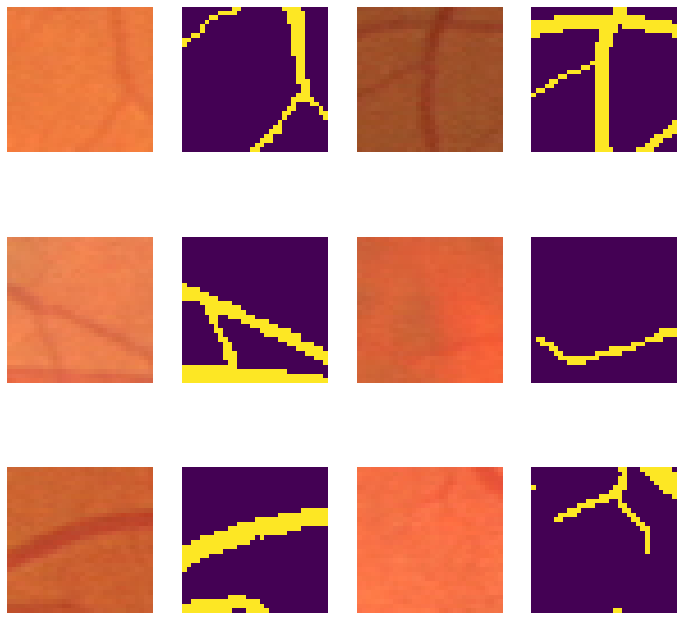

In [2]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [3]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [7]:
import os
sys.path.append('code/')
from unet_model import unet
from unet_utils import datagenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

(1, 584, 565, 3)
(1, 584, 565, 1)
Model: "model"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_1 (InputLayer)                   [(None, None, None, 3)]    0                                                     
________________________________________________________________________________________________________________________
conv2d (Conv2D)                        (None, None, None, 32)     896           input_1[0][0]                           
________________________________________________________________________________________________________________________
batch_normalization (BatchNormalizatio (None, None, None, 32)     128           conv2d[0][0]                            
________________________________________________________________________________________________________

50/50 - 200s - loss: 0.5374 - accuracy: 0.8079 - val_loss: 0.5276 - val_accuracy: 0.9211
Epoch 2/250
50/50 - 188s - loss: 0.3277 - accuracy: 0.9485 - val_loss: 0.3127 - val_accuracy: 0.9211
Epoch 3/250
50/50 - 195s - loss: 0.2220 - accuracy: 0.9580 - val_loss: 0.2666 - val_accuracy: 0.9211
Epoch 4/250
50/50 - 202s - loss: 0.2032 - accuracy: 0.9560 - val_loss: 0.3032 - val_accuracy: 0.9171
Epoch 5/250
50/50 - 195s - loss: 0.1840 - accuracy: 0.9523 - val_loss: 0.2984 - val_accuracy: 0.9215
Epoch 6/250
50/50 - 184s - loss: 0.1556 - accuracy: 0.9574 - val_loss: 0.3050 - val_accuracy: 0.9194
Epoch 7/250
50/50 - 184s - loss: 0.1293 - accuracy: 0.9608 - val_loss: 0.2672 - val_accuracy: 0.9222
Epoch 8/250
50/50 - 174s - loss: 0.1437 - accuracy: 0.9582 - val_loss: 0.2738 - val_accuracy: 0.9238
Epoch 9/250
50/50 - 126s - loss: 0.1228 - accuracy: 0.9611 - val_loss: 0.2738 - val_accuracy: 0.9261
Epoch 10/250
50/50 - 110s - loss: 0.1375 - accuracy: 0.9599 - val_loss: 0.2659 - val_accuracy: 0.9246
E

### Visualizing the segmentation results

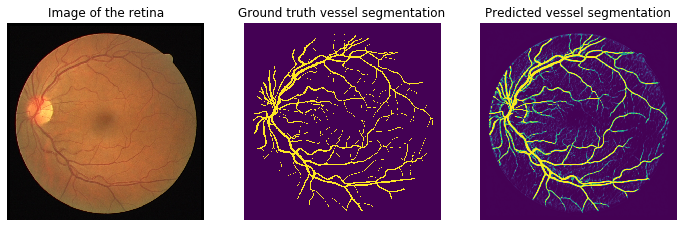

In [8]:
# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

# Exercises

## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

These parameters corresponds to the weights and the bias of that layer.

The input of the first convolutional layer is the image, so the input has 1 dimension. The filter size of the first concolutional layer is n=3 and m=3, or 3x3. Each filter contains 9 weights.(When the input has already s filers, then the filter size is nxmxs). Each filter has a bias, so the total of parameters of each filter is 9 + 1 = 10. There are 32 filter, so the total parameters are 10 * 32 = 320.

The first fully connected layer has a high number of paramaters, beachse every neuron is connected to every other neuron. The number of neurons of the previous layer are 9216. When we added the bias, it makes 9217. The number of neurons of the current layer are 128. The total number of parameters are 9217 * 128 = 1179,776. 

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>

The general expressions are:
1) convolutional layer 
\begin{align}
Number\;of\;Parameters = ((m * n * s) + 1) * k 
\end{align}
Where m is the shape of the width of the filer, n is the shape op the height of the filer, s is the number of input feature maps  and k is the number of output feature maps.
We addes 1 because of the bias term for each filter

1) Fully connected layer
\begin{align}
Number\;of\;Parameters = ((Neurons\;of\;previous\;layer + 1) * Neurons\;of\;current\;layer)
\end{align}


## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 



## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>


In the architecture of the U-net neural network you first start with downsampling the medical images. After a while you are going to upsample the image(s) again and now it is important to have these skip connections. Because it gives the opportunity to skip features of the contracting part to the expanding path and so it would be possible to recover some spatial information that would be lost during the downsampling procedure. 
Another benefit of skip connections in neural networks is that it can help the system with transfer information in a faster way into the deep neural network. 
What you can see is that Gradient information could get lost when passing through multiple layers of the DeepNN and this would give difficulties considering the gradient descent. With the skip connections you can pass some information to deeper layers and because of it classifying in more detail becomes easier for the system. 

It would be possible to train the exact same architecture without these skip connection, however as mentioned above, some of the spatial information can get loss during the downsampling procedure. When this information is not restored it would affect the result of the model in a negative way. The accuracy of the model will become lower for example. 

## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>

_Data augmentation is normally applied when there is not much training data available. Normally, when a model is be trained on a small dataset, overfitting occurs. However, when enlarging the training dataset by ‘creating’ new data that is similar to the existing data, the model can be trained on a bigger training set, so the model would not be overfitted._

_Data augmentation applied to the test set is called ‘test time augmentation’. Test time augmentation has the goal to make better predictions of the test set and is not involved in fitting a model. In test time augmentation, the test set is augmented multiple times and the output is averaged over the augmented versions of each test sample to obtain the final prediction._



Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above. 



In [15]:
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
import sys
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import gryds
sys.path.append('code/')
from unet_model import unet
from unet_utils import load_data, datageneratorbrn, extract_patches, preprocessing

# location of the DRIVE dataset
data_folder = './data/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns
val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

# example of brightness image augmentation
# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
#epochs = 250
epochs = 10
augm_size = (584, 565)
# 10 augmented images per image
augm_per_im = 2
steps_per_epoch = int(np.ceil((augm_per_im * len(train_images)) / batch_size))


# initialize model with brightness augmentation
modelbrn = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# compile the model
modelbrn.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = modelbrn.fit_generator(datageneratorbrn(X_train, y_train, augm_size, augm_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

# run the model on one test image and show the results

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = modelbrn.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()



ImportError: cannot import name 'datageneratorbrn' from 'unet_utils' (code\unet_utils.py)

Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.
